In [1]:
import torch
import torch.nn as nn 
import torchvision
from collections import OrderedDict
from torchvision.transforms.transforms import F
from PIL import Image
import copy
import numpy as np 
import os 
import json
from src.arch.models import SinglePersonPoseEtimator

json_path = './annotations/mpii/fullannotations.json'
joint_table_path = './annotations/mpii/jointtable.json'
joint_path = './annotations/mpii/jointdict.json'
histogram_path = './annotations/mpii/histogram.json'
images_path = './images/mpii_resized'
joint_table_tensor_path = './images/mpii_table/jointtable.pt'

with open(json_path, 'r') as fp:
    json_list = json.load(fp)
    
with open(joint_table_path, 'r') as fp:
    joint_table_list = json.load(fp)
    
def simulate_yolo_output(image_object):
    image_name = image_object['image_name']
    original = F.to_tensor(Image.open(os.path.join(images_path, image_name)))
    return [person_object['bbox'] for person_object in image_object['people']], original


In [17]:
image_index = 0
person_index = 0
image_object = json_list[image_index]

bboxes, original = simulate_yolo_output(image_object)
model = SinglePersonPoseEtimator()
model.eval()

with torch.no_grad():
    output_table = model(original, bboxes, person_index)

In [18]:
truth_table = torch.load(joint_table_tensor_path)[0]

In [32]:
class MyCrossEntropyOperation():
    def __call__(self, Yhat, Y):
        return - Y * torch.log(Yhat) + (1 - Y) * torch.log(1 - Yhat)

class CustomLoss():
    def __init__(self):
        self.cross = MyCrossEntropyOperation()
        self.means = nn.MSELoss()
    
    def __call__(self, output_table, truth_table):
        output_table = output_table.reshape(-1, 6)
        truth_table = truth_table.reshape(-1, 6)

        true_mask = truth_table[:, 5]
        out_mask = output_table[:, 5]

        coordinates_error = self.means(output_table[:, :4], truth_table[:, :4])
        visible_error = self.cross(output_table[:, 4], truth_table[:, 4])
        mask_error = self.cross(out_mask, true_mask)

        temp = mask_error + (coordinates_error + visible_error) * true_mask
        return torch.sum(temp)
    

my_loss = CustomLoss()


my_loss(output_table, truth_table)

tensor(50700.4414)

In [ ]:
cross = nn.CrossEntropyLoss()
in1 = torch.zeros()

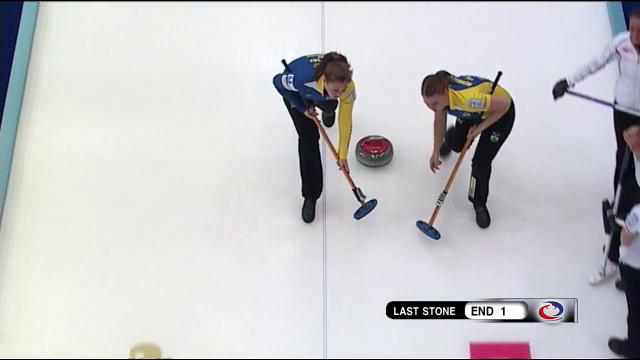

In [5]:
Image.open(os.path.join(images_path, '015601864.jpg'))

In [16]:
joint_table_tensor[3245]

tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00],
         [